In [1]:
import MGBlurr.blurring as blur
import MGTomo.functions as fcts
from MGTomo.utils import mylog, mydiv
from MGTomo.optimize import armijo_linesearch, box_bounds
from MGTomo.gridop import RBox as R, PBox as P
from MGTomo import gridop

from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.linalg import matrix_norm

import test_tomo

import time

In [2]:
N = 511
max_levels = 1
maxIter = [1,4,16,32,64]
kernel_size = 33
sigma = 10

# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [A[0](x_torch)]
P_nonzero = []

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim
    

In [3]:
def kl_distance(x: torch.tensor, A, b: torch.tensor):
    ax = A(x)
    ax.requires_grad_(True)
    #ab = torch.divide(ax, b)
    ab = mydiv(ax,b)
    
    erg = ax * mylog(ab) + b - ax
    fx = torch.sum( erg[b > 0.] ) + 0.5*torch.sum(ax[b == 0.]**2)
    #fx = torch.sum(erg[b > 0.])
    assert fx >= 0, fx
    #assert fx >= 0, 'kl distance error: output is negative.'
    return fx.requires_grad_(True)

In [4]:
tau = [0.5] * (max_levels+1)
fh = lambda x: kl_distance(x, A[0], b[0])
P_inf = 1

In [5]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if gcond:
        if y_last is not None:
            y_diff_norm = matrix_norm(y_last - y)
            y_norm = matrix_norm(y)
            return (y_diff_norm >= eta * y_norm)
        return True
    else:
        return False

In [6]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.49, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.clone().detach().requires_grad_(True) 
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    #fhy0.backward()
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y.clone().detach()
    
        x0 = x.clone().detach().requires_grad_(True)
        fH = lambda x: kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y, x, P_inf, lh, uh, P_nonzero[l])

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l]):
            x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1)

        d = P(x-x0)
        #fhy = fh(y)
        #fhy.backward()
        #y.grad
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.clone().detach().requires_grad_(True)
    return y, last_pts


In [7]:
# def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.49, eps = 0.001, verbose = True):
#     x = R(y).detach().requires_grad_(True)
#     y0, x0 = y, x.clone().detach().requires_grad_(True)
    
#     fhy0 = fh(y0)
#     fhy0.backward(retain_graph = True)
#     grad_fhy0 = y0.grad.clone()
#     y0.grad.zero_()
    
#     if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
#     #if coarse_condition_v3(grad_fhy0, kappa, eps):
#         print(l, ' : coarse correction activated')
#         last_pts[l] = y0.clone().detach()
    
#         fH = lambda x: kl_distance(x, A[l+1], b[l+1])
#         fHx0 = fH(x0)
#         fHx0.backward(retain_graph = True)
#         grad_fHx0 = x0.grad.clone()
#         x0.grad.zero_()

#         kappa = R(grad_fhy0) - grad_fHx0

#         psi = lambda x: fH(x) + torch.sum(kappa * x)
#         lH, uH = box_bounds(y0, x, P_inf, lh, uh, P_nonzero[l])

#         #x.retain_grad()
#         logvH_new = mylog(x - lH) - mylog(uH - x)
#         for i in range(maxIter[l]):
#             x.retain_grad()
#             val, logvH_new = fcts.BSMART_general(psi, x.detach(), logvH_new, tau[l+1], lH, uH)
#             x = val.clone().detach().requires_grad_(True)
            
#         if l < max_levels-1:
#             x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1, verbose=verbose)

#         d = P(x-x0)
#         z, _ = armijo_linesearch(fh, y0, d)
#         y = z.detach().requires_grad_(True)
        
#     else: 
#         print(l, ' : coarse correction not activated')

#     #y.retain_grad()
#     logvh_new = mylog(y - lh) - mylog(uh - y)
#     for i in range(maxIter[l]):
#         y.retain_grad()
#         yval, logvh_new = fcts.BSMART_general(fh, y.detach(), logvh_new, tau[l], lh, uh)
#         y = yval.clone().detach().requires_grad_(True)
#     return y, last_pts

In [8]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

logv_new = (w0 - lh) / (uh - w0)
w0.retain_grad()
#fh(w0).backward()
#w0.grad

fcts.BSMART_general(fh, w0, logv_new, 0.5, lh, uh)

(tensor([[0.7429, 0.7544, 0.7544,  ..., 0.7521, 0.7521, 0.7417],
         [0.7544, 0.7763, 0.7763,  ..., 0.7720, 0.7721, 0.7521],
         [0.7544, 0.7763, 0.7763,  ..., 0.7720, 0.7720, 0.7521],
         ...,
         [0.6318, 0.5199, 0.5201,  ..., 0.7440, 0.7440, 0.7376],
         [0.6317, 0.5198, 0.5200,  ..., 0.7440, 0.7440, 0.7376],
         [0.6835, 0.6317, 0.6318,  ..., 0.7376, 0.7376, 0.7343]]),
 tensor([[1.0611, 1.1222, 1.1221,  ..., 1.1099, 1.1100, 1.0550],
         [1.1222, 1.2444, 1.2442,  ..., 1.2198, 1.2200, 1.1100],
         [1.1222, 1.2442, 1.2441,  ..., 1.2197, 1.2199, 1.1100],
         ...,
         [0.5398, 0.0797, 0.0803,  ..., 1.0667, 1.0667, 1.0334],
         [0.5396, 0.0794, 0.0800,  ..., 1.0667, 1.0668, 1.0334],
         [0.7698, 0.5396, 0.5400,  ..., 1.0334, 1.0334, 1.0167]]))

In [ ]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

w0.retain_grad()

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, 0.5, lh, uh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 37791.6306309434 - Time: 1.957467 seconds
Iteration 1: 15424.153639797372 - Time: 2.213789 seconds
Iteration 2: 6096.296692740449 - Time: 1.867995 seconds
Iteration 3: 2670.69177231935 - Time: 1.847037 seconds
Iteration 4: 1330.2127402954497 - Time: 1.989503 seconds
Iteration 5: 741.272701909533 - Time: 2.048791 seconds
Iteration 6: 451.2879285618355 - Time: 2.052430 seconds
Iteration 7: 294.29446122996706 - Time: 1.838255 seconds
Iteration 8: 202.85757042758593 - Time: 1.611665 seconds
Iteration 9: 146.58548872846762 - Time: 1.729590 seconds
Iteration 10: 110.43377761547262 - Time: 2.054569 seconds
Iteration 11: 86.35594247181035 - Time: 1.946662 seconds
Iteration 12: 69.7864922913281 - Time: 1.591272 seconds
Iteration 13: 58.0209886111767 - Time: 1.590722 seconds
Iteration 14: 49.406362744784246 - Time: 1.582308 seconds
Iteration 15: 42.90787481765901 - Time: 1.585104 seconds
Iteration 16: 37.86495962928112 - Time: 1.585950 seconds
Iteration 17: 33.84823919303754 - Time:

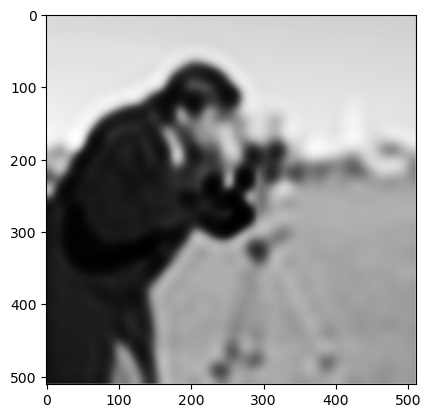

In [10]:
plt.imshow(w0.detach().numpy(), cmap = 'gray')

In [11]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

MLO_box(fh, z0, lh, uh, last_pts)

KeyboardInterrupt: 

In [ ]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(100):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

NameError: name 'coarse_condition_v2' is not defined